
# Why is there a high no-show rate to medical appointments in Brazil?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this project, I'll explore a dataset of no-show medical appointments in Brazil. The  dataset was originally published on Kaggle by [Joni Hoppen](https://www.kaggle.com/joniarroba "JoniHoppen") and can be found [here](https://www.kaggle.com/joniarroba/noshowappointments "here"). The main question that this dataset raises is whether it is possible to predict the likelihood of no-show appointments based on determining factors (demographics, medical information, time, etc.). While this project does not aim to model the probability of no-show appointments, we will nevertheless explore correlations between various elements and no-show appointment trends that would serve as the basis to build a predictive data model.

> A few notes about the dataset:
* 'scheduled_day' is the day on which the person scheduled the appointment & 'appointment_day' is the day of the actual medical visit.
* 'neighborhood' indicates the location of the hospital.
* ‘scholarship’ indicates whether or not the patient is enrolled in the Brasilian welfare system known as Programa Bolsa Família, introduced in 2003 by former president Lula da Silva. You can read more about the program [here](https://www.centreforpublicimpact.org/case-study/bolsa-familia-in-brazil/ "here"). A score of 1 means that the person received aid under the welfare program, whereas a score of 0 means that the person did not.
* The last column of the dataset, 'no_show', is encoded such that a "No" indicates that the person showed up for his/her/their medical appointment and a "Yes" indicates that the person did not show up.

> Now that we've provided a bit of context, let's start by importing the necessary packages for the analysis.

In [1164]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm;
%matplotlib inline
import seaborn as sns
import re

In [1165]:
no_show_df = pd.read_csv('noshowappt.csv')

In [1166]:
no_show_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [1167]:
no_show_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<a id='wrangling'></a>
## Data Wrangling



> As we notice from the printed data, it looks like the column names aren't uniform. Let's rename the columns so that they are all printed in lowercase. If the column name contains two words, let's also separate them using an underscore.

In [1168]:
# Add underscore before second upperscore letter of column names
original_col_names = list(no_show_df.columns)
new_col_names = []

for column_name in original_col_names:
    re_replace = re.sub(r'(?<=[a-z])(?=[A-Z])', '_', column_name)
    new_col_names.append(re_replace)

# Replace existing column names with the new ones stored in the new_col_names variable
no_show_df.columns = new_col_names

# Rename all column names to lowercase
no_show_df.rename(columns=lambda x: x.strip().lower(), inplace=True)

# Manually rename column names that contain spelling errors or weren't captured in the functions above
no_show_df.rename(columns={'hipertension':'hypertension',
                          'handcap':'handicap',
                          'no-show':'no_show'}, 
                          inplace=True)

> We also notice from the dataset summary that the datatype of columns 'scheduled_day' and 'appointment_day' appears to be an object, representing text or a combination of numeric and non-numeric values, even though the columns seem to be of datetime type. Let's convert the datatype from object to datetime.

In [1169]:
#changing datatype of columns 'scheduled_day' and 'appointment_day'

no_show_df['scheduled_day'] = pd.to_datetime(no_show_df['scheduled_day'])
no_show_df['appointment_day'] = pd.to_datetime(no_show_df['appointment_day'])

no_show_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns, UTC]
appointment_day    110527 non-null datetime64[ns, UTC]
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns, UTC](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


> As we see from the dataset summary, the columns 'scheduled_day' and 'appointment_day' have now been changed to datetime. Let's now investigate the 'age' column. Let's first sort the rows by ascending age values and investigate low and high age values.

In [1170]:
no_show_df.sort_values(by=['age'], inplace=True)

In [1171]:
no_show_df[(no_show_df.age < 0) | (no_show_df.age > 100)]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No
90372,2.342836e+11,5751563,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,No
58014,9.762948e+14,5651757,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,No
63915,3.196321e+13,5700279,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30 09:44:51+00:00,2016-05-30 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,No
68127,3.196321e+13,5562812,F,2016-04-08 14:29:17+00:00,2016-05-16 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
63912,3.196321e+13,5700278,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes
97666,7.482346e+14,5717451,F,2016-05-19 07:57:56+00:00,2016-06-03 00:00:00+00:00,115,SÃO JOSÉ,0,1,0,0,0,1,No


> From the query above, it looks like there are 8 rows with age values below 0 and above 100. We can also confirm with a boxplot the age distribution for both female and male patients.

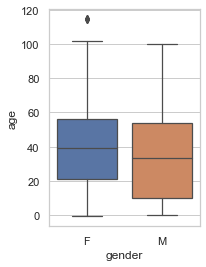

In [1172]:
plt.figure(figsize=(2.7,4))
sns.boxplot(x = 'gender', y="age", order = ['F','M'], data=no_show_df, linewidth=1.25);

> Based on the table above, the age value of 102 doesn't seem particularly unusual: advancements in the medical field have led to an increase in life expectancy over time, making centenarians more common now than before. However, there are inconsistencies in the `age` column that need to be inspected. We notice that there seems to be two supercentanarians (based on the patient ID) with an age of 115. According to the [Gerontology Research Group](http://www.grg.org/SC/WorldSCRankingsList.html "Gerontology Research Group"), there were only 5 Brazilian supercentanarians and all died before even reaching the age of 115. Based on the lack of documentation to determine the validity of the datapoints, I'll remove those 5 rows altogether to avoid skewing the results.

In [1173]:
no_show_df = no_show_df[(no_show_df.age > 0) & (no_show_df.age < 115)]

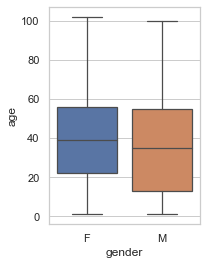

In [1174]:
plt.figure(figsize=(2.7,4))
sns.boxplot(x = 'gender', y="age", order = ['F','M'], data=no_show_df, linewidth=1.25);

> There also appear to be appointments scheduled after the appointment date itself, which could have happened because of poor data entry or because the file was overwritten. Regardless, I decided to remove those rows to avoid misrepresenting the data.

In [1186]:
no_show_df['days_between_scheduling_and_appointment'] =  \
(no_show_df['appointment_day'] - no_show_df['scheduled_day']).dt.days
no_show_df = no_show_df[(no_show_df.days_between_scheduling_and_appointment >= 0)]

> Now that we've sanitized the data, let's start exploring the questions first asked in the introduction section of this analysis. I'll start by exploring the relationship between demographics and no-show appointment data. I'll then investigate the impact of time on no-show appointment trends. Finally, I'll briefly study the correlation between medical information and the likelihood of observing no-show appointments.

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Is demographic information indicative of no-show appointments?

> Let's now focus on the demographics of our population (gender, age, neighborhood). Note: The following exploratory analysis does not take into account the fact that one patient may appear multiple times in the dataset. I decided to keep duplicated `patient_id` to avoid misrepresenting the number of no-shows.

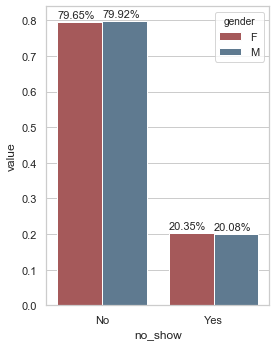

In [1176]:
crosstab= pd.crosstab(no_show_df['gender'],no_show_df['no_show']).apply(lambda r: r/r.sum(), axis=1)

stacked = crosstab.stack().reset_index().rename(columns={0:'value'})
color = sns.color_palette("Set1", n_colors=8, desat=.5)

plt.figure(figsize=(4, 5.5))

g = sns.barplot(x=stacked.no_show, y=stacked.value, hue=stacked.gender, palette = color)

# create a list to collect the plotted shape object
totals = []

# find the values and append to list
for i in g.patches:
    totals.append(i.get_height())

# set individual bar labels using list above
total = sum(totals)

# display individual bar labels
for i in g.patches:
    g.text(i.get_x(), i.get_height()+0.01, \
            str(round(i.get_height()*100, 2))+'%', fontsize=11)

> Here, gender by itself does not appear to be a significant factor of no-show appointments. The proportion of no-shows is fairly equivalent between male and female patients (approx. 20%).

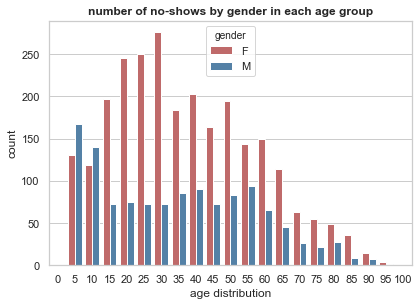

In [1244]:
no_show = no_show_df.loc[no_show_df['no_show'] == 'Yes']

fig = plt.figure(figsize=(6.5,4.5))

color = ['indianred','steelblue']

sns.countplot(data = no_show, x = 'age', hue = 'gender', 
              order=np.arange(0,no_show.age.max()+5,5), hue_order = ['F','M'],
              palette = color)

sns.set(style="whitegrid")

plt.title('number of no-shows by gender in each age group', fontweight= 'bold')
plt.xlabel('age distribution')
plt.show()

> Here, the data is a little more interesting. The barplot representing the age distribution of male patients is right-skewed. There appears to be more no-shows for male patients between the ages of 0 and 10 than in any other age group. \
There tends to be a higher number of no-shows for female patients in other age ranges, particularly between the ages of 15 and 60. \
As patients get older, there appears to be less no-show appointments. This is probably because older patients become increasingly vulnerable to ailments and can't afford to miss their medical appointment.

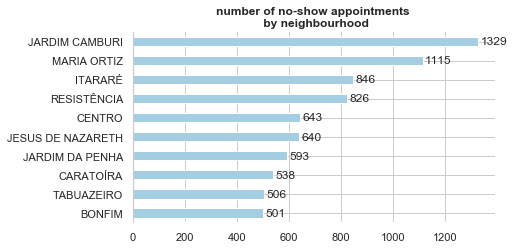

In [1204]:
fig = plt.figure(figsize=(6.5,3.5))

neighbourhood = no_show.neighbourhood.value_counts()[:10].sort_values().plot(kind = 'barh', colormap='Paired')
sns.despine(top=True, right=True, left=False, bottom=True)

for p in neighbourhood.patches:
    width = p.get_width()
    plt.text(p.get_width()+10, p.get_y()+0.5*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')

sns.set(style="whitegrid")
plt.title('number of no-show appointments \n by neighbourhood', fontweight = 'bold');

> The horizontal barplot above seems to point to the fact that region is a factor resulting in no-show appointments. The top three areas with the highest number of no-show appointments are Jardim Camburi, María Ortiz, and Itararé. Here, a mapping of the neighborhoods and regions in Brazil would be helpful to visualize no-show appointment trends across Brazil. It would help determine the reason why there are so many no-shows in the neighborhood of Jardim Camburi.

### Research Question 2: Is the day of week a significant determinant of no-show appointments?

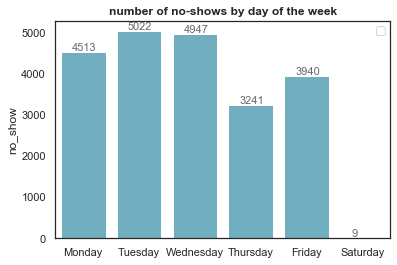

In [1179]:
no_show_df['weekday'] = no_show_df.appointment_day.apply(lambda dt: dt.weekday_name)

noshow_by_day = no_show_df.loc[no_show_df['no_show'] == 'Yes'].groupby('weekday',as_index = False)['no_show'].count()

#re-order weekdays
day_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
noshow_by_day = noshow_by_day.groupby(['weekday']).sum().reindex(day_of_week).reset_index()

# plot number of appointments during the week

sns.set(style="white")
graph = sns.barplot(data=noshow_by_day, x="weekday", y="no_show", color = sns.color_palette()[9])
plt.title('number of no-shows by day of the week', fontweight = 'bold')
plt.legend('');
plt.xlabel('');

#annotate each bar with number of no-shows by day of the week
# set individual bar lables using above list
for i in graph.patches:
    # get_x pulls left or right; get_height pushes up or down
    graph.text(i.get_x()+.2, i.get_height()+30, \
            str(int((i.get_height()))), fontsize=11, color='dimgrey')

> As we can see from the chart above, the days with the most no-shows are Tuesdays and Wednesdays, which tend the be the busiest days of the week.

### Research Question 3: Is the time between the scheduled and appointment day a good indicator of no-show appointments?

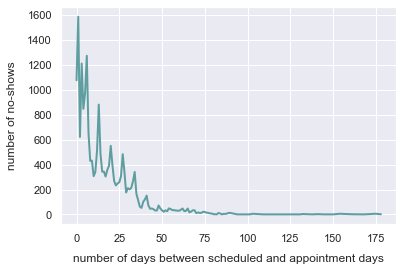

In [1212]:
time_slicer = no_show_df.loc[no_show_df['no_show'] == "Yes"]
time_slicer = no_show.groupby(['days_between_scheduling_and_appointment'], as_index = False)['no_show'].count()

sns.set(style="darkgrid")
plt.plot( 'days_between_scheduling_and_appointment', 'no_show', data=time_slicer, color='cadetblue', linewidth=2)
plt.xlabel("number of days between scheduled and appointment days", labelpad=10);
plt.ylabel("number of no-shows", labelpad=10);

> Interestingly, the number of no-show appointments increases as the time between the scheduled visit and the medical appointment narrows. It seems like patients who schedule their visit far in advance are extremely reliable. Those patients probably have more serious medical conditions that require tending. However, it is not apparent from the graph above and would require further analysis by examining the patients' various medical conditions.

### Research Question 4: How do medical conditions affect the likelihood of no-show appointments?

> Let's now turn to medical conditions of the patients. Although this portion of the analysis goes beyond Exploratory Data Analysis, it'll nevertheless provide useful insights. They can help determine whether the correlation between medical conditions and no-show appointments is worth investigating. We will look at the relationship between no-show appointment data and the ailments that patients suffer from, namely hypertension, diabetes, alcoholism, and handicap(s). In this regression, we'll use three variables: hypertension, diabetes, and alcoholism. We'll have to explore handicaps later as the variable isn't encoded in a binary way.

In [1181]:
# Create dummy variables for the 'no-show' column
no_show_df[['show','noshow']] = pd.get_dummies(no_show_df['no_show'])

# Drop 'show' column because encoded variable will appear under the 'noshow' column
no_show_df = no_show_df.drop('show', axis=1)

# Set the intercept
no_show_df['intercept'] = 1

#Fit a logistic regression using three levels: hypertension, diabetes, and handicap
log_mod = sm.Logit(no_show_df['noshow'], no_show_df[['intercept', 'hypertension', 'alcoholism','diabetes']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 279.880928
         Iterations 5


/Users/chloelubin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/chloelubin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/chloelubin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3409: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noshow   No. Observations:               106977
Model:                          Logit   Df Residuals:                   106973
Method:                           MLE   Df Model:                            3
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:                     inf
Time:                        14:47:22   Log-Likelihood:            -2.9941e+07
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.3250      0.008   -155.902      0.000      -1.342      -1.308
hypertension    -0.2424      0.022    -11.029      0.000      -0.286      -0.199
alcoholism       0.0393      0.044      0.896      0.370      -0.047       0.125
diabetes         0.0023      0.034      0.069      0.945      -0.063       0.068
================================================================================
"""

In [1182]:
"""
Exponentiate coefficients (and compute reciprocal of coefficient < 1) 
to determine the multiplicative change in the odds of a "1" for every 
one unit increase of the variable.
"""

(1/np.exp(-0.2424)), np.exp(0.0393), (1/np.exp(0.0023))

(1.2743038124104453, 1.040082461589604, 0.997702642973332)

> We can see from the logistic regression results summary above that only hypertension seems to be statistically significant, with a p-value below the conventional threshold of 0.05. Furthermore, with every one unit decrease in hypertension, it is 1.27 times more likely that the patient won't show up for their appointment, holding all else constant. We can do a similar analysis based on the number of handicaps that a patient has. 

In [1183]:
dummies = pd.get_dummies(no_show_df['handicap'], prefix='handicap', prefix_sep='_')
no_show_df = pd.concat([no_show_df, dummies], axis = 1)

#Fit a logistic regression using four levels of handicap
log_mod = sm.Logit(no_show_df['noshow'], no_show_df[['intercept','handicap_1', 'handicap_2', 'handicap_3', 'handicap_4']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 278.996633
         Iterations 5


/Users/chloelubin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/chloelubin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/chloelubin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3409: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noshow   No. Observations:               106977
Model:                          Logit   Df Residuals:                   106972
Method:                           MLE   Df Model:                            4
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:                     inf
Time:                        14:47:24   Log-Likelihood:            -2.9846e+07
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3672      0.008   -178.006      0.000      -1.382      -1.352
handicap_1    -0.1669      0.059     -2.851      0.004      -0.282      -0.052
handicap_2    -0.0055      0.184     -0.030      0.976      -0.367       0.356
handicap_3     0.1633      0.658      0.248      0.804      -1.127       1.454
handicap_4     0.6741      1.225      0.550      0.582      -1.726       3.075
==============================================================================
"""

In [1184]:
1/np.exp(-0.1669)

1.181636095790405

> Once again, only one variable appears to be statistically significant to determine the likelihood of a no-show: 'handicap_1'. In order to interpret the `handicap_1` coefficient, we need to once again compute the reciprocal of the coefficient. Based on the result, it appears that, with every one unit decrease of a patient's single handicap, it is 1.18 times more likely that the patient won't show up for their appointment, holding all else constant.

<a id='conclusion'></a>
## Conclusion

* The `gender` variable isn't a significant factor contributing to the high number of no-show appointments by itself. Combined with age, we see that there is a higher no-show rate for male patients between the ages of 0 and 10 and betwen 15 and 60 years old for female patients. We also observe that older patients of both genders seem more reliable to show up to their appointment.
* Timing also matters a lot in the likelihood of observing a no-show. There is a higher number of no-shows on Tuesdays and Wednesdays. In addition, patients who scheduled their appointment far in advance seemed to have a lower number of no-show appointments than those who scheduled theirs within a shorter timeframe.
* Finally, medical conditions are determining factors that can be used to estimate the probability of a no-show. As we notice from our analysis above, two medical conditions in particular seem to affect the no-show rate: hypertension and having a single handicap.

> After identifying important factors contributing to the high no-show rate, we are now able to build a predictive model that would determine the outcome based on various demographic, temporal and medical factors.

### Additional Sources:

* https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

* http://blog.quizzicol.com/2016/10/03/sorting-dates-in-python-by-day-of-week/

* https://stackoverflow.com/questions/25674532/pythonic-way-to-add-space-before-capital-letter-if-and-only-if-previous-letter-i